<a href="https://colab.research.google.com/github/ainsleyyjongg/dl_intro/blob/main/convolution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# What you will learn
1. Convolutional layers and the convolution operation
1. Pooling layers
1. Confusion matrix

### CODE CELL 1

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision as vision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.optim import SGD,Adam

## Convolutional Network

Convolutional neural network are very successfully in computer vision applications. They have the ability to progressively detect patterns in images and videos. Usually, the first few layers detect "low level" features such as lines and edges and, building on those, later layers detect more complicated features such as faces and objects.

### Convolution Operations
We start with a simple example. Let I be an input image. Typically $I$ would be represented by a tensor of shape $(H,W,C)$ where $H$, $W$, and $C$ are the height, width, and color channel respectively. Therefore,  $I[h,w,c]$ refers to the value of channel $c$ in pixel $(h,w)$. Let $K$ be a filter with shape $(m,n)$ then the convolution operation produces the following tensor
\begin{align*}
T_{i,j}=\sum_c\sum_{m,n}X_{i+m,j+n,c}*K_{m,n}
\end{align*}
The above operation is illustrated in the example below. Click on the figures to see the sequence of operations.


In [2]:

%%HTML
<iframe src="https://docs.google.com/presentation/d/e/2PACX-1vQBSo0SLsiigeXPOP4MGOS55ez9hvRT0xWocjs16K7U4JMTD1UnHXrNAu43qRo_GQ/embed?start=true&loop=true&delayms=3000" frameborder="0" width="500" height="300" allowfullscreen="true" mozallowfullscreen="true" webkitallowfullscreen="true"></iframe>

## Pooling
Pooling replaces a region of the input with a "summary" statistic, usually the maximum. This makes the computation almost translation invariant.

### Pooling example

In the example below, notice how the MaxPool2D picks the maximum from each 2x2 submatrix

In [3]:
input=torch.tensor([[1,2,4,3],[5,6,8,7],[9,10,12,11],[13,14,16,2]]).float()
# 1 sample, 1 channel, 4 height, 4 width
input=input.reshape([1,1,4,4])
output=nn.MaxPool2d(kernel_size=(2,2))(input)
print(input.squeeze())
print(output.squeeze())

tensor([[ 1.,  2.,  4.,  3.],
        [ 5.,  6.,  8.,  7.],
        [ 9., 10., 12., 11.],
        [13., 14., 16.,  2.]])
tensor([[ 6.,  8.],
        [14., 16.]])


## Data
The data is CIFAR10 with 50000 images for training and 10000 for testing. Each images has 3 channels and size 32x32.
As we have done before we convert the PIL images to tensor and then normalize the values. Since there are 3 channels we need 3 values for the mean and 3 for the standard deviation

In [4]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0, 0, 0), (0.5, 0.5, 0.5))])
dataset_train=vision.datasets.CIFAR10(".",download=True,train=True,transform=transform)
dataset_test=vision.datasets.CIFAR10(".",download=True,train=False,transform=transform)
loader_train=DataLoader(dataset_train,batch_size=64,shuffle=True,num_workers=2)
loader_test=DataLoader(dataset_test,batch_size=512,shuffle=False)

100%|██████████| 170M/170M [00:18<00:00, 9.21MB/s]


Extracting ./cifar-10-python.tar.gz to .
Files already downloaded and verified


## Model

- Our model uses a stack of convolutional and pooling layers.
- The last two layers are fully connected with the size of the output of the last one is 10 = number of classes
- Note that the output of convolutional layers a "3-d" objects so we need to "flatten" then before feeding them to the fully connected layers

In [13]:
class Net(nn.Module):
  def __init__(self):
    super().__init__()
    # input is (*,3,32,32)
    self.conv1=nn.Conv2d(in_channels=3,out_channels=32,kernel_size=3) # kernel size = 3 => is a 3x3 matrix, out_channels = 32 => use 32 kernels
    self.relu=nn.ReLU()
    # input is (*,32,30,30)
    self.pool1=nn.MaxPool2d(kernel_size=(2,2))
    # input is (*,32,15,15)
    self.conv2=nn.Conv2d(in_channels=32,out_channels=64,kernel_size=3)
    # input is (*,64,13,13)
    self.pool2=nn.MaxPool2d(kernel_size=(2,2))
    # input is (*,64,6,6)
    self.conv3=nn.Conv2d(in_channels=64,out_channels=64,kernel_size=3)
    # input is (*,64,4,4)
    self.pool3=nn.MaxPool2d(kernel_size=(2,2))
    # input is (*,64,2,2)
    self.flatten=nn.Flatten()
    # input is (*,64x2x2)
    self.fc1=nn.Linear(in_features=2*2*64,out_features=64)
    self.fc2=nn.Linear(in_features=64,out_features=10)

  def forward(self,x):
    x=self.conv1(x)
    x=self.relu(x)
    x=self.pool1(x)

    x=self.conv2(x)
    x=self.relu(x)
    x=self.pool2(x)

    x=self.conv3(x)
    x=self.relu(x)
    x=self.pool3(x)

    x=self.flatten(x)
    x=self.fc1(x)
    x=self.relu(x)
    x=self.fc2(x)
    return x


In [14]:
def get_accuracy(dataloader,model):
  total=len(dataloader.dataset.data)
  correct=0
  for data in dataloader:
    imgs,labels=data
    imgs=imgs.cuda()
    labels=labels.cuda()
    outputs=model(imgs)
  # the second return value is the index of the max i.e. argmax
    _,predicted=torch.max(outputs.data,1) # "_" => Output value, "predicted" => The index of Output value
    correct+=(predicted==labels).sum()


  return (correct/total).item()

Instantiate the model, the optimizer and the loss function

In [7]:
model=Net().cuda()
optimizer=Adam(model.parameters())
loss_fn=nn.CrossEntropyLoss()

## Training loop

In [8]:
epochs=3
from tqdm import tqdm
for epoch in range(epochs):
  loop=tqdm(loader_train)
  loop.set_description(f"Epoch [{epoch+1}/{epochs}]")
  for (imgs,labels) in loop:
    optimizer.zero_grad()
    imgs=imgs.cuda()
    labels=labels.cuda()
    outputs=model(imgs)
    loss=loss_fn(outputs,labels)
    loss.backward()
    optimizer.step()
    loop.set_postfix(loss=loss.item())

  acc=get_accuracy(loader_test,model)

Epoch [3/3]: 100%|██████████| 782/782 [00:18<00:00, 42.54it/s, loss=0.595]


# Accuracy and confusion matrix

One would like to measure the accuracy of the model at the end of the run. As important, to get an idea which class is more/less accurately predicted.

In [9]:
!pip install torchmetrics
from torchmetrics import ConfusionMatrix
conmat=ConfusionMatrix(task="multiclass",num_classes=10)
conmat=conmat.cuda()

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 890.6/890.6 kB 34.6 MB/s eta 0:00:00


In [10]:
total=0
correct=0
for data in loader_test:
  imgs,labels=data
  imgs=imgs.cuda()
  labels=labels.cuda()
  outputs=model(imgs)
  # the second return value is the index of the max i.e. argmax
  _,predicted=torch.max(outputs.data,1)
  correct+=(predicted==labels).sum()
  total+=labels.size()[0]
  conmat.update(predicted,labels)

In [11]:
print(correct/total)

tensor(0.5843, device='cuda:0')


Visualize the confusion matrix

<Axes: >

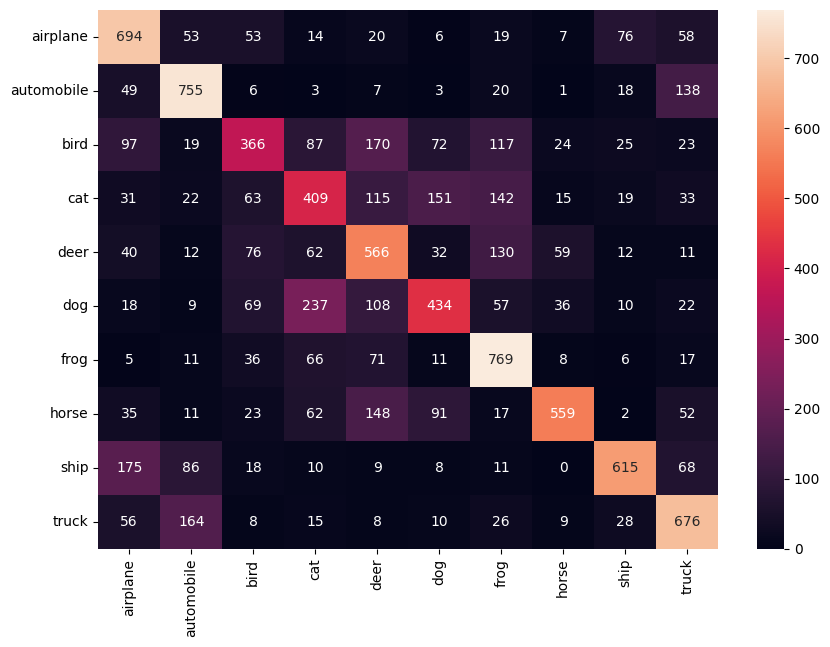

In [12]:
import matplotlib.pyplot as plt
import seaborn as sb
x=conmat.compute().cpu().numpy()
plt.figure(figsize=(10,7))
sb.heatmap(x,xticklabels=dataset_train.classes,yticklabels=dataset_train.classes,annot=True,fmt=".0f")